In [6]:
import spotipy
import pandas as pd
from spotipy.oauth2 import SpotifyClientCredentials # To access authorised Spotify data

In [7]:
#Credenciales

CLIENT_ID = ''
CLIENT_SECRET = ''

In [8]:

#https://open.spotify.com/playlist/37i9dQZEVXbJajpaXyaKll
#https://open.spotify.com/playlist/3vLhR9whyOipDlP3TlGaBb

PLAYLIST_ID = '3vLhR9whyOipDlP3TlGaBb'

In [9]:
# API Login

client_credentials_manager = SpotifyClientCredentials(client_id=CLIENT_ID, client_secret=CLIENT_SECRET)
sp = spotipy.Spotify(client_credentials_manager=client_credentials_manager) #spotify object to access API

In [10]:
# Getting tracks of the playlist

tracks = sp.user_playlist_tracks(user = 'spotify', playlist_id = PLAYLIST_ID)
tracks_uri_list = [x['track']['uri'] for x in tracks['items']]

In [11]:
# Getting features of tracks

features = []
for i in tracks_uri_list:
    features = features + sp.audio_features(i)

In [12]:
# Creating feature dataframe

cols_to_drop = ['id', 'analysis_url', 'key', 'time_signature', 'track_href', 'type', 'uri', 'mode', 'duration_ms']
features_df = pd.DataFrame(features).drop(cols_to_drop, axis=1)

In [13]:
features_original= pd.DataFrame(features)
features_df.head()

,danceability,energy,loudness,speechiness,acousticness,instrumentalness,liveness,valence,tempo
0,0.407,0.477,-10.202,0.0284,0.225,0.000173,0.1010,0.132,155.920
1,0.455,0.374,-14.893,0.0711,0.838,0.000003,0.7160,0.407,82.185
2,0.480,0.414,-8.855,0.0332,0.816,0.000089,0.0892,0.430,166.954
3,0.466,0.536,-6.308,0.0281,0.273,0.000000,0.1220,0.464,74.688
4,0.406,0.771,-6.991,0.0562,0.128,0.000000,0.1270,0.420,132.002


In [14]:
features_df.describe()

,danceability,energy,loudness,speechiness,acousticness,instrumentalness,liveness,valence,tempo
count,59.000000,59.000000,59.000000,59.000000,59.000000,59.000000,59.000000,59.000000,59.000000
mean,0.652525,0.649407,-6.426695,0.087819,0.305260,0.012322,0.229468,0.624600,124.796136
std,0.133172,0.196323,3.258550,0.084784,0.281279,0.058472,0.229819,0.206981,34.718854
min,0.315000,0.239000,-14.893000,0.026500,0.000025,0.000000,0.057400,0.052400,74.688000
25%,0.576000,0.468500,-8.378000,0.034950,0.051850,0.000000,0.096350,0.509000,94.045500
50%,0.674000,0.696000,-5.968000,0.052400,0.233000,0.000000,0.122000,0.680000,117.005000
75%,0.765500,0.800000,-3.525000,0.098700,0.436000,0.000057,0.233000,0.759000,148.948500
max,0.842000,0.991000,-2.409000,0.433000,0.928000,0.330000,0.978000,0.952000,209.786000


In [15]:
from sklearn.cluster import KMeans

# Scaling
for col in ['loudness', 'tempo']:
    features_df[col] = ((features_df[col] - features_df[col].min()) / (features_df[col].max() - features_df[col].min()))


    

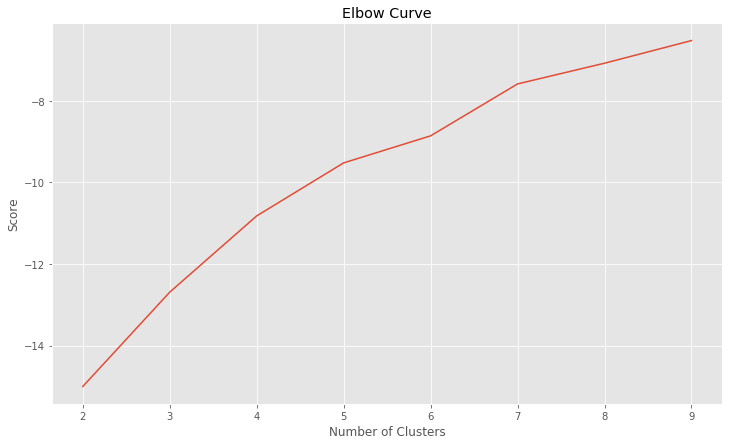

In [16]:
import matplotlib.pyplot as plt
import seaborn as sb
%matplotlib inline
from mpl_toolkits.mplot3d import Axes3D
plt.rcParams['figure.figsize'] = (16, 9)
plt.style.use('ggplot')

Nc = range(2, 10)
kmeans = [KMeans(n_clusters=i) for i in Nc]
score = [kmeans[i].fit(features_df).score(features_df) for i in range(len(kmeans))]

plt.figure(figsize=(12,7))
plt.plot(Nc,score)
plt.xlabel('Number of Clusters')
plt.ylabel('Score')
plt.title('Elbow Curve')
plt.show()

In [17]:
features_df_r= features_df[['energy','acousticness','loudness']].copy()

kmeans = KMeans(n_clusters=6).fit(features_df_r)
centroids = kmeans.cluster_centers_
print(centroids)

[[0.63525    0.16025    0.63555351]
 [0.82623529 0.06646797 0.88207965]
 [0.40722222 0.76277778 0.56851437]
 [0.78972727 0.36736364 0.89786199]
 [0.30333333 0.84566667 0.08365374]
 [0.48342857 0.21634286 0.30658672]]


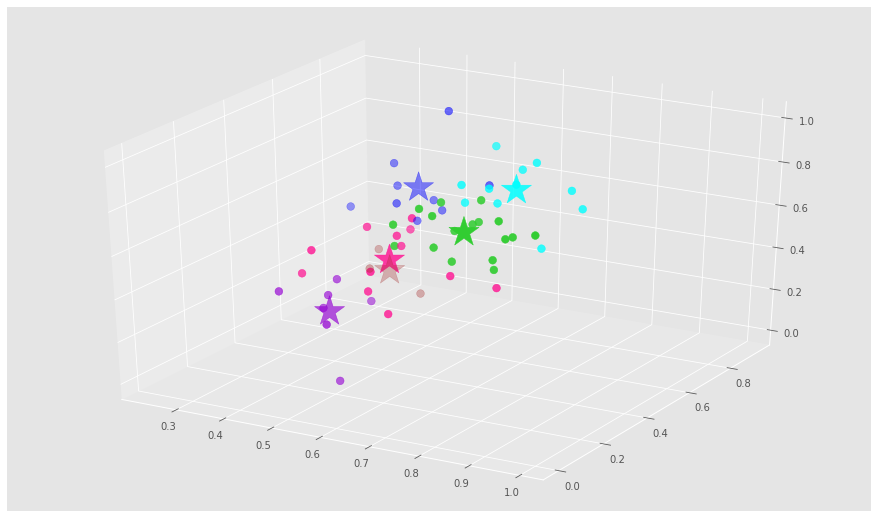

In [18]:
# Predicting the clusters
labels = kmeans.predict(features_df_r)

features_df_c = features_df.copy()
features_df_c['cluster'] = labels

features_df_c

# Getting the cluster centers
C = kmeans.cluster_centers_
colores=['deeppink','limegreen','blue','cyan','brown','darkviolet']
asignar=[]

for row in labels:
        asignar.append(colores[row])
     
fig = plt.figure(figsize=(12,7))
ax = Axes3D(fig)

ax.scatter(features_df_r['energy'], features_df_r['acousticness'], features_df_r['loudness'], c=asignar,s=60)
ax.scatter(C[:, 0], C[:, 1], C[:, 2], marker='*', c=colores, s=1000);



In [19]:
features_df_c.head()

,danceability,energy,loudness,speechiness,acousticness,instrumentalness,liveness,valence,tempo,cluster
0,0.407,0.477,0.375761,0.0284,0.225,0.000173,0.1010,0.132,0.601282,5
1,0.455,0.374,0.000000,0.0711,0.838,0.000003,0.7160,0.407,0.055493,4
2,0.480,0.414,0.483659,0.0332,0.816,0.000089,0.0892,0.430,0.682956,2
3,0.466,0.536,0.687680,0.0281,0.273,0.000000,0.1220,0.464,0.000000,0
4,0.406,0.771,0.632970,0.0562,0.128,0.000000,0.1270,0.420,0.424240,0


In [20]:
# Extracting song and artist names
songs = [x['track']['name'] for x in tracks['items']]
artists = [x['track']['artists'] for x in tracks['items']]

# Concatenating multiple artist names
artist_list = []
for group in artists:
    artist_group = []
    for person in group:
        artist_group.append(person['name'])
    artist_list.append(', '.join(artist_group))



In [21]:
resultado = pd.concat([features_original, features_df_c], axis=1)
resultado.head()

,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,...,danceability,energy,loudness,speechiness,acousticness,instrumentalness,liveness,valence,tempo,cluster
0,0.407,0.477,7,-10.202,1,0.0284,0.225,0.000173,0.1010,0.132,...,0.407,0.477,0.375761,0.0284,0.225,0.000173,0.1010,0.132,0.601282,5
1,0.455,0.374,0,-14.893,1,0.0711,0.838,0.000003,0.7160,0.407,...,0.455,0.374,0.000000,0.0711,0.838,0.000003,0.7160,0.407,0.055493,4
2,0.480,0.414,2,-8.855,1,0.0332,0.816,0.000089,0.0892,0.430,...,0.480,0.414,0.483659,0.0332,0.816,0.000089,0.0892,0.430,0.682956,2
3,0.466,0.536,2,-6.308,1,0.0281,0.273,0.000000,0.1220,0.464,...,0.466,0.536,0.687680,0.0281,0.273,0.000000,0.1220,0.464,0.000000,0
4,0.406,0.771,4,-6.991,0,0.0562,0.128,0.000000,0.1270,0.420,...,0.406,0.771,0.632970,0.0562,0.128,0.000000,0.1270,0.420,0.424240,0


In [22]:
#CLUSTER 0

cluster0 = resultado[resultado['cluster']==0].copy()
list0= cluster0.index.values
songnames = [songs[i] for i in list0]
artistnames =  [artist_list[i] for i in list0]

cluster0['song'] = songnames
cluster0['artist'] = artistnames
cluster0[['song','artist','id','energy','acousticness','loudness']]


,song,artist,id,energy,energy,acousticness,acousticness,loudness,loudness
3,Amanece En La Ruta,Fabiana Cantilo,5pKVGrmItsCubKWTrYpxSZ,0.536,0.536,0.2730,0.2730,-6.308,0.687680
4,Balada Del Diablo y La Muerte,La Renga,4ObkiTmpsSU31gqGhTb8SH,0.771,0.771,0.1280,0.1280,-6.991,0.632970
13,La trama y el desenlace,Jorge Drexler,563EHELbGcAwXlAHbWmK3f,0.491,0.491,0.0936,0.0936,-7.965,0.554950
22,Amárrame,"Mon Laferte, Juanes",0jTJlKUegj0w7crcxzxqhj,0.626,0.626,0.2110,0.2110,-5.981,0.713874
24,Quero Ser Feliz Também - Ao Vivo,Natiruts,3b8vIZo54D5aIHjukUCYuy,0.550,0.550,0.4270,0.4270,-7.402,0.600048
25,Me Namora (feat. Edu Ribeiro) - Ao Vivo,"Natiruts, Edu Ribeiro",0gRNBFAXFhq1Z8QgTd0aXI,0.847,0.847,0.1600,0.1600,-7.516,0.590916
31,Anónimos,"Los Pericos, Carla Morrison",6pKADEM7gx8EZ6UypMUzyd,0.603,0.603,0.2770,0.2770,-7.108,0.623598
34,Por Eso Vine,Paulo Londra,5qN1G8fSHq4Sv5FRoOkNGu,0.646,0.646,0.2330,0.2330,-5.048,0.788609
37,Electricity (with Dua Lipa),"Silk City, Dua Lipa, Diplo, Mark Ronson",5N4erncE7kuUccm7zEmwzk,0.670,0.670,0.0104,0.0104,-6.439,0.677187
40,Whine Up,DJ Martin V,1zxynAV8sUvric6fnTx8B8,0.638,0.638,0.0649,0.0649,-8.077,0.545979


In [23]:
features_df_0 = features_df_c[features_df_c['cluster']==0].copy()
features_df_0.describe()

,danceability,energy,loudness,speechiness,acousticness,instrumentalness,liveness,valence,tempo,cluster
count,12.000000,12.000000,12.000000,12.000000,12.000000,12.000000,12.000000,12.000000,12.000000,12.0
mean,0.616250,0.635250,0.635554,0.072992,0.160250,0.000115,0.282450,0.663583,0.452328,0.0
std,0.113799,0.103391,0.082740,0.114061,0.128182,0.000349,0.279445,0.198857,0.317264,0.0
min,0.406000,0.491000,0.501602,0.026500,0.008100,0.000000,0.085400,0.307000,0.000000,0.0
25%,0.577500,0.547500,0.581925,0.031475,0.057925,0.000000,0.100875,0.494750,0.266564,0.0
50%,0.594000,0.632000,0.628284,0.038500,0.144000,0.000005,0.120500,0.735500,0.468712,0.0
75%,0.726500,0.678750,0.693067,0.049525,0.243000,0.000029,0.427750,0.777250,0.613068,0.0
max,0.760000,0.847000,0.788609,0.433000,0.427000,0.001220,0.781000,0.920000,1.000000,0.0


In [24]:
features_df_0.head()

,danceability,energy,loudness,speechiness,acousticness,instrumentalness,liveness,valence,tempo,cluster
3,0.466,0.536,0.687680,0.0281,0.2730,0.000000,0.122,0.464,0.000000,0
4,0.406,0.771,0.632970,0.0562,0.1280,0.000000,0.127,0.420,0.424240,0
13,0.579,0.491,0.554950,0.0342,0.0936,0.000057,0.119,0.721,0.557499,0
22,0.573,0.626,0.713874,0.0453,0.2110,0.001220,0.116,0.767,0.779775,0
24,0.755,0.550,0.600048,0.0265,0.4270,0.000000,0.697,0.757,0.127848,0


In [25]:
#CLUSTER 1

cluster1 = resultado[resultado['cluster']==1].copy()
list1= cluster1.index.values
songnames = [songs[i] for i in list1]
artistnames =  [artist_list[i] for i in list1]

cluster1['song'] = songnames
cluster1['artist'] = artistnames
cluster1[['song','artist','id','energy','acousticness','loudness']]

,song,artist,id,energy,energy,acousticness,acousticness,loudness,loudness
5,Smells Like Teen Spirit,Nirvana,1f3yAtsJtY87CTmM8RLnxf,0.912,0.912,0.000025,0.000025,-4.556,0.828020
6,Rollin' (Air Raid Vehicle),Limp Bizkit,3IV4swNduIRunHREK80owz,0.933,0.933,0.005910,0.005910,-3.358,0.923983
7,Que Tire Pa Lante,Daddy Yankee,6RyaV7owmVU6fzEPE17sF1,0.901,0.901,0.047800,0.047800,-2.814,0.967558
10,Baila Baila Baila,Ozuna,7uH27oIt4a6cIFCA8ZPcyG,0.754,0.754,0.036100,0.036100,-2.750,0.972685
14,No Me Acuerdo,"Thalía, Natti Natasha",00EPIEnX1JFjff8sC6bccd,0.799,0.799,0.187000,0.187000,-4.247,0.852772
15,Lento,"Thalía, Gente De Zona",4IcdqpHrf0ZcAh61fRAJ6N,0.931,0.931,0.041000,0.041000,-3.497,0.912848
23,Amor (Ft. Mon Laferte) - Mtv Unplugged,"Los Auténticos Decadentes, Mon Laferte",2fscHtYDKLd7xYRCTe3prP,0.818,0.818,0.033900,0.033900,-5.317,0.767062
27,Me Gusta,"Shakira, Anuel AA",5Xhqh4lwJPtMUTsdBztN1a,0.696,0.696,0.055900,0.055900,-5.184,0.777715
28,Cristal,Estelares,2Ii5KZkSNr1nb6ZokIU3Qx,0.718,0.718,0.005810,0.005810,-3.579,0.906280
29,Deléctrico,Babasónicos,5DSgzNSlB4EHCIi8YAXxWn,0.907,0.907,0.016400,0.016400,-5.222,0.774672


In [26]:
features_df_1 = features_df_c[features_df_c['cluster']==1].copy()
features_df_1.describe()

,danceability,energy,loudness,speechiness,acousticness,instrumentalness,liveness,valence,tempo,cluster
count,17.000000,17.000000,17.000000,17.000000,17.000000,17.000000,17.000000,17.000000,17.000000,17.0
mean,0.678176,0.826235,0.882080,0.089788,0.066468,0.017770,0.223759,0.690235,0.265666,1.0
std,0.138230,0.086471,0.072441,0.057577,0.071688,0.072730,0.217713,0.159208,0.187293,0.0
min,0.399000,0.696000,0.767062,0.028800,0.000025,0.000000,0.064200,0.202000,0.061504,1.0
25%,0.597000,0.771000,0.828020,0.047200,0.012500,0.000000,0.106000,0.677000,0.142793,1.0
50%,0.694000,0.801000,0.906280,0.068100,0.036100,0.000000,0.157000,0.709000,0.160017,1.0
75%,0.794000,0.907000,0.949856,0.111000,0.146000,0.000005,0.249000,0.772000,0.313854,1.0
max,0.842000,0.991000,0.972685,0.228000,0.188000,0.300000,0.978000,0.952000,0.735155,1.0


In [27]:
features_df_1.head()

,danceability,energy,loudness,speechiness,acousticness,instrumentalness,liveness,valence,tempo,cluster
5,0.502,0.912,0.828020,0.0564,0.000025,0.000173,0.106,0.720,0.311426,1
6,0.603,0.933,0.923983,0.1710,0.005910,0.000000,0.206,0.709,0.160017,1
7,0.658,0.901,0.967558,0.0357,0.047800,0.000000,0.120,0.708,0.142793,1
10,0.816,0.754,0.972685,0.1110,0.036100,0.000000,0.217,0.533,0.187109,1
14,0.836,0.799,0.852772,0.0873,0.187000,0.000000,0.092,0.772,0.143192,1


In [28]:
#CLUSTER 2

cluster2 = resultado[resultado['cluster']==2].copy()
list2= cluster2.index.values
songnames = [songs[i] for i in list2]
artistnames =  [artist_list[i] for i in list2]

cluster2['song'] = songnames
cluster2['artist'] = artistnames
cluster2[['song','artist','id','energy','acousticness','loudness']]

,song,artist,id,energy,energy,acousticness,acousticness,loudness,loudness
2,Canción de Amor,Lisandro Aristimuño,0qNsOLnssvhNjjBHimImcO,0.414,0.414,0.816,0.816,-8.855,0.483659
12,Dance Monkey,Tones And I,2XU0oxnq2qxCpomAAuJY8K,0.588,0.588,0.692,0.692,-6.400,0.680311
16,Memories,Maroon 5,2b8fOow8UzyDFAE27YhOZM,0.320,0.320,0.837,0.837,-7.209,0.615508
17,I Don't Care - Acoustic,Ed Sheeran,1m84zLz4WizjR4mCDoXReg,0.349,0.349,0.791,0.791,-8.125,0.542134
18,Everyday Life,Coldplay,6WMf0Om41Z6HlMzXFuZ4F0,0.453,0.453,0.771,0.771,-8.991,0.472765
30,Todo Pasa,Carla Morrison,2S3Y5RJ0qKLg47jAhkcisO,0.420,0.420,0.639,0.639,-7.875,0.562160
47,FRIENDS - Acoustic,"Marshmello, Anne-Marie",7cWAu4fGyUN2XAET9fuvxR,0.460,0.460,0.786,0.786,-3.261,0.931753
50,Antes de Huir,Natalia Lafourcade,4j6ym6CZ3v9lpWaVzcudUq,0.422,0.422,0.725,0.725,-9.457,0.435437
55,Asilo (feat. Mon Laferte),"Jorge Drexler, Mon Laferte",41gpbNDcsSh4r8YgVMbQqh,0.239,0.239,0.808,0.808,-9.988,0.392903


In [29]:
features_df_2 = features_df_c[features_df_c['cluster']==2].copy()
features_df_2.describe()

,danceability,energy,loudness,speechiness,acousticness,instrumentalness,liveness,valence,tempo,cluster
count,9.000000,9.000000,9.000000,9.000000,9.000000,9.000000,9.000000,9.000000,9.000000,9.0
mean,0.628000,0.407222,0.568514,0.048011,0.762778,0.010247,0.113544,0.458044,0.338382,2.0
std,0.130255,0.098289,0.162904,0.025221,0.064757,0.030433,0.043273,0.209646,0.244286,0.0
min,0.480000,0.239000,0.392903,0.027100,0.639000,0.000000,0.065000,0.052400,0.120883,2.0
25%,0.512000,0.349000,0.472765,0.030200,0.725000,0.000000,0.089200,0.367000,0.143377,2.0
50%,0.596000,0.420000,0.542134,0.033200,0.786000,0.000031,0.108000,0.513000,0.253934,2.0
75%,0.735000,0.453000,0.615508,0.054600,0.808000,0.000104,0.111000,0.624000,0.390798,2.0
max,0.824000,0.588000,0.931753,0.092400,0.837000,0.091400,0.211000,0.683000,0.779264,2.0


In [30]:
features_df_2.head()

,danceability,energy,loudness,speechiness,acousticness,instrumentalness,liveness,valence,tempo,cluster
2,0.480,0.414,0.483659,0.0332,0.816,0.000089,0.0892,0.430,0.682956,2
12,0.824,0.588,0.680311,0.0924,0.692,0.000104,0.1490,0.513,0.172756,2
16,0.764,0.320,0.615508,0.0546,0.837,0.000000,0.0822,0.575,0.120883,2
17,0.706,0.349,0.542134,0.0302,0.791,0.000000,0.1080,0.624,0.143377,2
18,0.512,0.453,0.472765,0.0291,0.771,0.091400,0.0650,0.236,0.365379,2


In [31]:
#CLUSTER 3

cluster3 = resultado[resultado['cluster']==3].copy()
list3= cluster3.index.values
songnames = [songs[i] for i in list3]
artistnames =  [artist_list[i] for i in list3]

cluster3['song'] = songnames
cluster3['artist'] = artistnames
cluster3[['song','artist','id','energy','acousticness','loudness']].head()

,song,artist,id,energy,energy,acousticness,acousticness,loudness,loudness
8,Tusa,"KAROL G, Nicki Minaj",7k4t7uLgtOxPwTpFmtJNTY,0.715,0.715,0.295,0.295,-3.280,0.930231
9,Muévelo,"Nicky Jam, Daddy Yankee",4VgYtXCVJ7IbWAZ5ryfvEQ,0.807,0.807,0.416,0.416,-2.409,1.000000
11,Calma - Remix,"Pedro Capó, Farruko",5iwz1NiezX7WWjnCgY5TH4,0.773,0.773,0.323,0.323,-4.218,0.855095
19,Beso a Beso,"La Mona Jimenez, Hugh Padgham, Sergio Oliva",7aEYUsqdL77wcXuyQf8XEL,0.879,0.879,0.281,0.281,-5.968,0.714915
20,El Bum Bum,"La Mona Jimenez, Sergio Oliva",06WHI8UMxwVatRUuJwrOhp,0.909,0.909,0.391,0.391,-4.354,0.844201


In [32]:
features_df_3 = features_df_c[features_df_c['cluster']==3].copy()
features_df_3.describe()

,danceability,energy,loudness,speechiness,acousticness,instrumentalness,liveness,valence,tempo,cluster
count,11.000000,11.000000,11.000000,11.000000,11.000000,11.000000,11.000000,11.000000,11.000000,11.0
mean,0.753000,0.789727,0.897862,0.131955,0.367364,0.000097,0.146764,0.758273,0.430361,3.0
std,0.074008,0.080781,0.080900,0.104401,0.095029,0.000259,0.144654,0.130652,0.240837,0.0
min,0.595000,0.652000,0.714915,0.048900,0.273000,0.000000,0.057400,0.574000,0.127789,3.0
25%,0.710500,0.737000,0.849648,0.054350,0.293000,0.000000,0.067050,0.679000,0.187816,3.0
50%,0.780000,0.773000,0.929269,0.097700,0.323000,0.000000,0.097500,0.761000,0.498312,3.0
75%,0.806000,0.855500,0.937079,0.166000,0.410500,0.000035,0.146500,0.849500,0.550323,3.0
max,0.826000,0.909000,1.000000,0.336000,0.581000,0.000868,0.565000,0.940000,0.839339,3.0


In [33]:
features_df_3.head()

,danceability,energy,loudness,speechiness,acousticness,instrumentalness,liveness,valence,tempo,cluster
8,0.803,0.715,0.930231,0.2980,0.295,0.000134,0.0574,0.574,0.195391,3
9,0.595,0.807,1.000000,0.0489,0.416,0.000014,0.5650,0.919,0.839339,3
11,0.826,0.773,0.855095,0.0524,0.323,0.000000,0.1430,0.761,0.386468,3
19,0.669,0.879,0.714915,0.0977,0.281,0.000000,0.1500,0.657,0.558787,3
20,0.809,0.909,0.844201,0.1070,0.391,0.000000,0.0975,0.779,0.498312,3


In [34]:
#CLUSTER 4

cluster4 = resultado[resultado['cluster']==4].copy()
list4= cluster4.index.values
songnames = [songs[i] for i in list4]
artistnames =  [artist_list[i] for i in list4]

cluster4['song'] = songnames
cluster4['artist'] = artistnames
cluster4[['song','artist','id','energy','acousticness','loudness']]

,song,artist,id,energy,energy,acousticness,acousticness,loudness,loudness
1,A Primera Vista - En Vivo,Pedro Aznar,5ILO4muNGt6OcH0sEQjyTG,0.374,0.374,0.838,0.838,-14.893,0.000000
49,Para Qué Sufrir,Natalia Lafourcade,4nehxVflg443IcjhsqpfEG,0.240,0.240,0.928,0.928,-13.391,0.120314
51,"Free Fallin' - Live at the Nokia Theatre, Los ...",John Mayer,4LloVtxNZpeh7q7xdi1DQc,0.296,0.296,0.771,0.771,-13.262,0.130647


In [35]:
features_df_4 = features_df_c[features_df_c['cluster']==4].copy()
features_df_4.describe()

,danceability,energy,loudness,speechiness,acousticness,instrumentalness,liveness,valence,tempo,cluster
count,3.000000,3.000000,3.000000,3.000000,3.000000,3.000000,3.000000,3.000000,3.000000,3.0
mean,0.484667,0.303333,0.083654,0.046667,0.845667,0.000010,0.507667,0.368333,0.364585,4.0
std,0.186280,0.067300,0.072630,0.021338,0.078780,0.000016,0.348790,0.093222,0.337709,0.0
min,0.315000,0.240000,0.000000,0.031700,0.771000,0.000000,0.105000,0.262000,0.055493,4.0
25%,0.385000,0.268000,0.060157,0.034450,0.804500,0.000001,0.403500,0.334500,0.184362,4.0
50%,0.455000,0.296000,0.120314,0.037200,0.838000,0.000003,0.702000,0.407000,0.313232,4.0
75%,0.569500,0.335000,0.125481,0.054150,0.883000,0.000016,0.709000,0.421500,0.519131,4.0
max,0.684000,0.374000,0.130647,0.071100,0.928000,0.000029,0.716000,0.436000,0.725029,4.0


In [36]:
features_df_4.head()

,danceability,energy,loudness,speechiness,acousticness,instrumentalness,liveness,valence,tempo,cluster
1,0.455,0.374,0.000000,0.0711,0.838,0.000003,0.716,0.407,0.055493,4
49,0.684,0.240,0.120314,0.0372,0.928,0.000029,0.105,0.262,0.313232,4
51,0.315,0.296,0.130647,0.0317,0.771,0.000000,0.702,0.436,0.725029,4


In [37]:
#CLUSTER 5

cluster5 = resultado[resultado['cluster']==5].copy()
list5= cluster5.index.values
songnames = [songs[i] for i in list5]
artistnames =  [artist_list[i] for i in list5]

cluster5['song'] = songnames
cluster5['artist'] = artistnames
cluster5[['song','artist','id','energy','acousticness','loudness']]

,song,artist,id,energy,energy,acousticness,acousticness,loudness,loudness
0,Un Pacto,Bersuit Vergarabat,4J2Jf2GvaOSINTlTTHdmse,0.477,0.477,0.2250,0.2250,-10.202,0.375761
32,De Nada Sirve,"No Te Va Gustar, Jorge Drexler",2CFDPiNUxcSOqfQtUHYNxF,0.457,0.457,0.3030,0.3030,-9.911,0.399071
33,Tuyo Siempre,"Bersuit Vergarabat, Andrés Calamaro",6YwniGmDxEvKmHkwFPmv2x,0.568,0.568,0.0344,0.0344,-10.110,0.383130
36,bad guy (with Justin Bieber),"Billie Eilish, Justin Bieber",3yNZ5r3LKfdmjoS3gkhUCT,0.453,0.453,0.2520,0.2520,-11.265,0.290612
41,Tu Vida Mi Vida,Fito Paez,3UA8Vjo0hQXGJnoeQF1SOL,0.543,0.543,0.1340,0.1340,-14.276,0.049423
57,Royals,Lorde,2dLLR6qlu5UJ5gk0dKz0h3,0.428,0.428,0.1210,0.1210,-9.504,0.431673
58,Desde Que Te Perdí - En Vivo,"Kevin Johansen, Natalia Lafourcade",4MkDZKiVWLLL3TTEhJRHVk,0.458,0.458,0.4450,0.4450,-12.191,0.216437


In [38]:
features_df_5 = features_df_c[features_df_c['cluster']==5].copy()
features_df_5.describe()

,danceability,energy,loudness,speechiness,acousticness,instrumentalness,liveness,valence,tempo,cluster
count,7.000000,7.000000,7.000000,7.000000,7.000000,7.000000,7.000000,7.000000,7.000000,7.0
mean,0.598000,0.483429,0.306587,0.107914,0.216343,0.047170,0.312286,0.512286,0.437973,5.0
std,0.109371,0.051778,0.135006,0.099564,0.135471,0.124716,0.279242,0.216617,0.296843,0.0
min,0.407000,0.428000,0.049423,0.028400,0.034400,0.000000,0.101000,0.132000,0.075427,5.0
25%,0.555000,0.455000,0.253525,0.034500,0.127500,0.000000,0.121500,0.413500,0.195510,5.0
50%,0.590000,0.458000,0.375761,0.062000,0.225000,0.000000,0.132000,0.549000,0.446839,5.0
75%,0.672000,0.510000,0.391101,0.150500,0.277500,0.000096,0.463000,0.661000,0.679581,5.0
max,0.735000,0.568000,0.431673,0.295000,0.445000,0.330000,0.784000,0.756000,0.793365,5.0


In [39]:
features_df_5.head()

,danceability,energy,loudness,speechiness,acousticness,instrumentalness,liveness,valence,tempo,cluster
0,0.407,0.477,0.375761,0.0284,0.2250,0.000173,0.101,0.132,0.601282,5
32,0.585,0.457,0.399071,0.0373,0.3030,0.000018,0.784,0.490,0.757879,5
33,0.590,0.568,0.383130,0.0620,0.0344,0.000000,0.305,0.756,0.793365,5
36,0.670,0.453,0.290612,0.2950,0.2520,0.330000,0.117,0.680,0.446839,5
41,0.735,0.543,0.049423,0.0317,0.1340,0.000000,0.126,0.549,0.305704,5
